Select input source:
1. Webcam
2. Recorded video file

Final Inferred Mood: Down or Depressed
Mood Consistency: Moderately stable


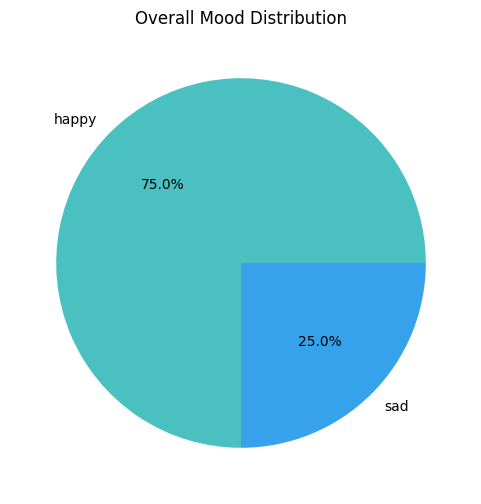

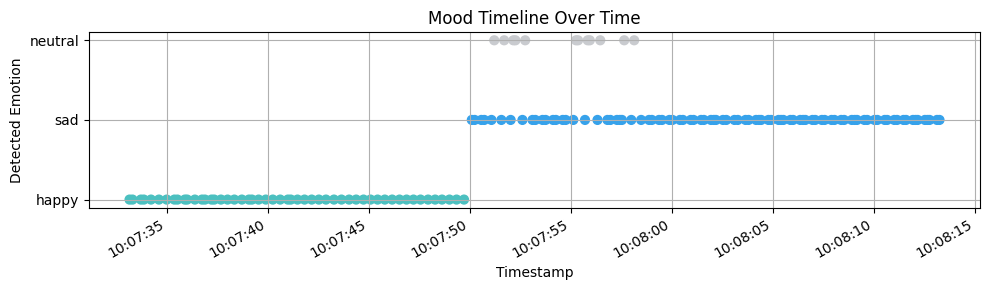

In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import model_from_json
from collections import deque, Counter
from sklearn.cluster import KMeans
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from collections import Counter
from fpdf import FPDF
import datetime
from datetime import datetime
from numpy.fft import fft2, fftshift

def load_emotion_model(json_path, weights_path):
    with open(json_path, "r") as json_file:
        model = model_from_json(json_file.read())
    model.load_weights(weights_path)
    return model

# Emotions and colors
emotion_colors = {
    'angry': (255, 99, 132), 'disgust': (153, 102, 255), 'fear': (255, 206, 86),
    'happy': (75, 192, 192), 'sad': (54, 162, 235), 'surprise': (255, 159, 64),
    'neutral': (201, 203, 207)
}
emotion_labels = list(emotion_colors.keys())

# Haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")

model = load_emotion_model(r"./Data/model.json", 
                           r"./Data/model.weights.h5"
                           )

frame_emotions = []
timestamp_emotions = []
frame_smiles = []
frame_eyes_open = []
recent_predictions = deque(maxlen=30)
smoothed_prediction = np.zeros(len(emotion_labels))
current_inferred_mood = "Unknown"

def initialize_video_writer(cap, output_dir="recordings", filename="session.avi"):
    os.makedirs(output_dir, exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 20
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(f"{output_dir}/{filename}", fourcc, fps, (width, height))
    return out, f"{output_dir}/{filename}"

def draw_overlay(frame, inferred_mood):
    cv2.rectangle(frame, (0, 0), (frame.shape[1], 40), (50, 50, 50), -1)
    cv2.putText(frame, f"Press 'Q' to quit | Mood: {inferred_mood}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Mood inference
def infer_mood_from_ema(pred_array):
    idx = np.argmax(pred_array)
    label = emotion_labels[idx]
    happy, sad, surprise, neutral, angry = pred_array[3], pred_array[4], pred_array[5], pred_array[6], pred_array[0]

    # More nuanced mapping
    if happy > 0.5 and surprise > 0.2:
        return "Euphoric"
    elif happy > 0.4:
        return "Cheerful"
    elif sad > 0.5:
        return "Down or Depressed"
    elif neutral > 0.6:
        return "Calm or Disconnected"
    elif angry > 0.3:
        return "Frustrated or Angry"
    else:
        return label.capitalize()

# Stability analysis
def analyze_mood_stability(emotion_sequence):
    if len(emotion_sequence) < 2:
        return "Insufficient data"
    switches = sum(1 for i in range(1, len(emotion_sequence)) if emotion_sequence[i] != emotion_sequence[i-1])
    ratio = switches / len(emotion_sequence)
    if ratio < 0.1:
        return "Stable"
    elif ratio < 0.3:
        return "Moderately stable"
    else:
        return "Erratic"

emotion_counts = {emotion: 0 for emotion in emotion_labels}

# Mood meter on screen
def draw_mood_meter(frame, prediction_array):
    bar_x, bar_y = 10, frame.shape[0] - 50
    bar_height = 30
    section_width = int((frame.shape[1] - 20) / len(prediction_array))
    for i, score in enumerate(prediction_array):
        width = int(score * section_width)
        color = emotion_colors[emotion_labels[i]]
        cv2.rectangle(frame, (bar_x + i*section_width, bar_y),
                      (bar_x + i*section_width + width, bar_y + bar_height),
                      color, -1)
        cv2.putText(frame, emotion_labels[i], (bar_x + i*section_width, bar_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Contrast enhancement
def enhance_contrast(gray_image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray_image)

# EMA smoothing
def update_smoothed_prediction(new_pred, alpha=0.3):
    global smoothed_prediction
    smoothed_prediction = alpha * new_pred + (1 - alpha) * smoothed_prediction
    return smoothed_prediction

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def remove_non_latin1(text):
    return text.encode('latin-1', errors='ignore').decode('latin-1')

# Mood-based duas and trivia
def get_dua_and_trivia(mood):
    duas = {
        "Frustrated or Angry": (
            "O Allah, help me control my anger.",
            "Quran: Restrain anger and forgive others. (3:134)",
            "Hadith: Strong is the one who controls anger. (Bukhari)",
            "Trivia: Deep breathing helps manage anger."
        ),
        "Disgust": (
            "O Allah, clean my heart from negativity.",
            "Quran: Come to Allah with a pure heart. (26:88)",
            "Hadith: Love for others what you love for yourself. (Bukhari)",
            "Trivia: Empathy can reduce feelings of disgust."
        ),
        "Fear": (
            "O Allah, remove fear and give me calm.",
            "Quran: Allah doesn’t burden a soul beyond its capacity. (2:286)",
            "Hadith: Constantly seek forgiveness for relief. (Abi Dawood)",
            "Trivia: Naming your fear can reduce its power."
        ),
        "Happy": (
            "O Allah, let happiness make me grateful.",
            "Quran: Allah’s blessings are countless. (16:18)",
            "Hadith: Thank people to thank Allah. (Abi Dawood)",
            "Trivia: Gratitude increases happiness."
        ),
        "Cheerful": (
            "O Allah, let my joy bring me closer to You.",
            "Quran: Countless are Allah’s blessings. (16:18)",
            "Hadith: Smiling is charity. (Tirmidhi)",
            "Trivia: Smiling boosts your mood."
        ),
        "Sad": (
            "O Allah, lift sadness from my heart.",
            "Quran: Nothing happens without Allah’s will. (9:51)",
            "Hadith: Sadness removes sins. (Bukhari)",
            "Trivia: Crying helps release stress."
        ),
        "Down or Depressed": (
            "O Allah, lift sadness from my heart.",
            "Quran: Nothing happens without Allah’s will. (9:51)",
            "Hadith: Sadness removes sins. (Bukhari)",
            "Trivia: Crying helps release stress."
        ),
        "Surprise": (
            "O Allah, keep me steady in surprises.",
            "Quran: Life and death are by Allah’s will. (3:145)",
            "Hadith: All matters are good for a believer. (Muslim)",
            "Trivia: Surprises trigger happiness in the brain."
        ),
        "Neutral": (
            "O Allah, keep me connected to You always.",
            "Quran: Return to your Lord with peace. (89:27)",
            "Hadith: Allah looks at your heart and deeds. (Muslim)",
            "Trivia: Mindfulness builds resilience."
        ),
        "Calm or Disconnected": (
            "O Allah, keep me connected to You always.",
            "Quran: Return to your Lord with peace. (89:27)",
            "Hadith: Allah looks at your heart and deeds. (Muslim)",
            "Trivia: Mindfulness builds resilience."
        )
    }

    dua, quran_ref, hadith_ref, trivia = duas.get(mood, (
        "No dua found", "No Quran reference found", "No Hadith reference found", "No trivia found"
    ))

    return (
        remove_non_latin1(dua),
        remove_non_latin1(quran_ref),
        remove_non_latin1(hadith_ref),
        remove_non_latin1(trivia)
    )


# PDF report generator
def generate_mood_pdf_report(frame_emotions, mood, timestamp, dua, quran_ref,hadith_ref, trivia, emotion_colors, gender, stress_level):
    counter = Counter(frame_emotions)
    fig1 = Figure(figsize=(4, 4))  # Initialize the figure
    canvas1 = FigureCanvas(fig1)
    ax1 = fig1.add_subplot(111)
    ax1.pie(counter.values(), labels=counter.keys(),
            colors=[np.array(emotion_colors[e]) / 255 for e in counter.keys()],
            autopct='%1.1f%%')
    ax1.set_title("Mood Distribution")
    fig1.tight_layout()
    fig1.savefig("./Mood_Graphs/mood_pie.png")

    # Start creating PDF
    pdf = FPDF()
    pdf.add_page()

    # Title
    pdf.set_font("Arial", 'B', 20)
    pdf.set_text_color(0, 102, 204)  # Blue
    pdf.cell(200, 10, txt=" Mood Detection Report ", ln=True, align='C')

    pdf.set_text_color(0, 0, 0)  # Reset to black
    pdf.set_font("Arial", size=12)
    pdf.ln(10)

    # Session Info Section
    pdf.set_font("Arial", 'B', 14)
    pdf.set_text_color(255, 0, 102)  # Pink
    pdf.cell(200, 10, txt=" Session Information", ln=True)

    pdf.set_font("Arial", size=12)
    pdf.set_text_color(0, 0, 0)
    pdf.cell(200, 10, txt=f" Session Time: {timestamp}", ln=True)
    pdf.cell(200, 10, txt=f" Inferred Mood: {mood}", ln=True)

    # Add Gender and Stress Level Information
    pdf.ln(5)
    pdf.set_font("Arial", size=12)
    pdf.set_text_color(0, 0, 0)
    pdf.cell(200, 10, txt=f" Gender: {gender}", ln=True)
    pdf.cell(200, 10, txt=f" Stress Level: {stress_level}", ln=True)

    # Dua Section
    pdf.ln(5)
    pdf.set_font("Arial", 'B', 14)  # Bold for the heading
    pdf.set_text_color(0, 153, 0)  # Green for title
    pdf.cell(200, 10, txt="Dua & Reflection", ln=True)

    # Reset font color and size for content
    pdf.set_text_color(0, 0, 0)  # Black for content
    pdf.set_font("Arial", '', 12)  # Regular font with size 12 (no bold)

    # Clean the text (remove non-latin characters)
    dua = remove_non_latin1(dua)
    quran_ref = remove_non_latin1(quran_ref)
    hadith_ref = remove_non_latin1(hadith_ref)

    # Display content without bold (font size 12, black color)
    pdf.multi_cell(0, 10, txt=f"Dua: {dua}")
    pdf.multi_cell(0, 10, txt=f"Quran Reference: {quran_ref}")
    pdf.multi_cell(0, 10, txt=f"Hadith Reference: {hadith_ref}")

    # Trivia Section
    pdf.ln(5)
    pdf.set_font("Arial", 'B', 14)
    pdf.set_text_color(255, 128, 0)  # Orange
    pdf.cell(200, 10, txt=" Mood Trivia", ln=True)

    pdf.set_font("Arial", size=12)
    pdf.set_text_color(0, 0, 0)
    pdf.multi_cell(0, 10, txt=f" {trivia}")

    # Mood Distribution Chart
    pdf.ln(10)
    pdf.set_font("Arial", 'B', 14)
    pdf.set_text_color(51, 102, 255)
    pdf.cell(200, 10, txt=" Mood Distribution", ln=True)
    pdf.image("./Mood_Graphs/mood_pie.png", x=60, w=90)

    # Mood Over Time Chart
    pdf.ln(10)
    pdf.set_font("Arial", 'B', 14)
    pdf.set_text_color(102, 0, 204)  # Purple
    pdf.cell(200, 10, txt=" Mood Over Time", ln=True)
    pdf.image("./Mood_Graphs/mood_over_time.png", x=40, w=130)

    # Save PDF
    filename = f"./Mood_Graphs/mood_report_{mood}_{timestamp.replace(' ', '_').replace(':', '-')}.pdf"
    pdf.output(filename)
    print(f"\n Mood report generated and saved as: {filename}")

def enhance_contrast(image):
    # Histogram equalization for contrast enhancement
    return cv2.equalizeHist(image)

def face_distance_tracker(frame, faces, min_distance=40, max_distance=100, reference_face_size=80, focal_length=500):
    for (x, y, w, h) in faces:
        # Calculate the face center
        face_center = (x + w // 2, y + h // 2)

        # Use width of the face to estimate the distance (using reference size and focal length)
        face_size = w  # We use the width of the face for simplicity
        distance = (reference_face_size * focal_length) / face_size  # Distance estimation using formula

        # Display the face bounding box (for reference)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green color for bounding box

        # Determine if the face is too close, too far, or at the perfect distance
        if distance < min_distance:
            cv2.putText(frame, "Move Closer", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (128, 0, 128), 2)  # Purple color
        elif distance > max_distance:
            cv2.putText(frame, "Move Back", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (128, 0, 128), 2)  # Purple color
        else:
            cv2.putText(frame, "Perfect Distance", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)  # Green color

    return frame

def preprocess_image(frame):
    # 1. Convert to Grayscale
    Gray_Image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 2. Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(Gray_Image, (5, 5), 0)

    # 3. Median Blur
    median_blur = cv2.medianBlur(gaussian_blur, 5)

    # 4. Edge Detection (Sobel)
    sobel_x = cv2.Sobel(median_blur, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(median_blur, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = cv2.magnitude(sobel_x, sobel_y)
    edge_magnitude = np.uint8(np.clip(edge_magnitude, 0, 255))

    # Return all as separate values
    return Gray_Image, gaussian_blur, median_blur, edge_magnitude


def draw_mood_meter(frame, smoothed_prediction):
    h, w = frame.shape[:2]
    x_start = w - 180
    for idx, prob in enumerate(smoothed_prediction):
        color = emotion_colors[emotion_labels[idx]]
        cv2.rectangle(frame, (x_start, 45 + idx*25),
              (x_start + int(prob*100), 65 + idx*25), color, -1)
        cv2.putText(frame, f"{emotion_labels[idx]} {prob:.2f}",
            (x_start, 45 + idx*25 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

def detect_emotions(frame, frame_count):
    global frame_emotions, timestamp_emotions, frame_smiles, frame_eyes_open, current_inferred_mood

    # Preprocess the image (grayscale, denoising, edge detection, etc.)
    Gray_Image, gaussian_blur, median_blur, edge_magnitude= preprocess_image(frame)

    # Detect faces
    faces = face_cascade.detectMultiScale(Gray_Image)
    smile_detected, eyes_open = 0, 0

    for (x, y, w, h) in faces:
        roi_gray = Gray_Image[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi = img_to_array(roi_gray)
        roi = np.expand_dims(roi, axis=0) / 255.0

        # Emotion prediction (model inference)
        prediction = model.predict(roi, verbose=0)[0]
        smoothed = update_smoothed_prediction(prediction)

        label = emotion_labels[np.argmax(smoothed)]
        timestamp_emotions.append((datetime.now(), label))

        if frame_count % 30 == 0:
            frame_emotions.append(label)

        # Smile and eye detection
        face_roi = Gray_Image[y:y+h, x:x+w]
        smiles = smile_cascade.detectMultiScale(face_roi, scaleFactor=1.8, minNeighbors=20)
        eyes = eye_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=5)
        if len(smiles) > 0: smile_detected = 1
        if len(eyes) >= 2: eyes_open = 1

        draw_mood_meter(frame, smoothed)
        color = emotion_colors[label]
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y + h + 200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

    frame_smiles.append(smile_detected)
    frame_eyes_open.append(eyes_open)

    # Inferred mood based on EMA (Exponential Moving Average)
    current_inferred_mood = infer_mood_from_ema(smoothed_prediction)
    draw_overlay(frame, current_inferred_mood)

    # Get the dua and reference based on the current inferred mood
    dua, quran_ref, hadith_ref, trivia = get_dua_and_trivia(current_inferred_mood)
    y_offset = 100  # Adjusted to make more space for extra lines

    # Get the color for the current emotion
    emotion_color = emotion_colors.get(current_inferred_mood, (0, 0, 0))

    # White background for readability (larger box to fit more lines)
    cv2.rectangle(frame, (10, frame.shape[0] - y_offset - 40),
                  (frame.shape[1] - 10, frame.shape[0] - 10), (255, 255, 255), -1)

    # Label "Dua:" stays black for contrast
    cv2.putText(frame, "Dua:", (10, frame.shape[0] - y_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    # Dua text
    cv2.putText(frame, dua, (10, frame.shape[0] - y_offset + 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, emotion_color, 1)

    # Quran Reference
    cv2.putText(frame, f"Quran Ref: {quran_ref}", (10, frame.shape[0] - y_offset + 45),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, emotion_color, 1)

    # Hadith Reference
    cv2.putText(frame, f"Hadith Ref: {hadith_ref}", (10, frame.shape[0] - y_offset + 65),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, emotion_color, 1)
    
    # Trivia
    cv2.putText(frame, trivia, (10, frame.shape[0] - y_offset + 85),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, emotion_color, 1)

    return frame

def display_final_summary():
    if not frame_emotions:
        print("No faces detected.")
        return
    mood = infer_mood_from_ema(smoothed_prediction)
    stability = analyze_mood_stability(frame_emotions)
    print(f"\nFinal Inferred Mood: {mood}")
    print(f"Mood Consistency: {stability}")

    counter = Counter(frame_emotions)
    plt.figure(figsize=(6, 6))
    plt.pie(counter.values(), labels=counter.keys(),
            colors=[np.array(emotion_colors[e])/255 for e in counter.keys()],
            autopct='%1.1f%%')
    plt.title("Overall Mood Distribution")
    plt.show()

# Mood timeline
def plot_mood_timeline():
    if not timestamp_emotions:
        return
    times = [t[0] for t in timestamp_emotions]
    labels = [t[1] for t in timestamp_emotions]
    colors = [emotion_colors[label] for label in labels]

    plt.figure(figsize=(10, 3))
    plt.scatter(times, labels, c=np.array(colors)/255, s=40)
    plt.gcf().autofmt_xdate()
    plt.title("Mood Timeline Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Detected Emotion")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("./Mood_Graphs/mood_over_time.png")
    plt.show()

def prompt_view_saved_video(video_path):
    choice = input("Do you want to view the saved session video? (y/n): ").lower()
    if choice == 'y' and os.path.exists(video_path):
        os.system(f'start {video_path}')
    elif choice == 'y':
        print("Saved video not found.")

def calculate_stress_level(eye_blink_rate, eyebrow_frequency, jaw_clench):
    if eyebrow_frequency > 5 or eye_blink_rate > 20:
        return "High"
    elif eyebrow_frequency > 2 or eye_blink_rate > 10:
        return "Medium"
    else:
        return "Low"
    
# Load pre-trained models
def predict_gender(frame, face, gender_model, confidence_threshold=0.6):
    (x, y, w, h) = face
    face_roi = frame[y:y+h, x:x+w]

    # Check if the region is valid
    if face_roi.size == 0 or w < 20 or h < 20:
        return "Uncertain"

    try:
        # Resize and prepare blob
        face_resized = cv2.resize(face_roi, (227, 227))
        blob = cv2.dnn.blobFromImage(face_resized, 1.0, (227, 227),
                                     (78.4263377603, 87.7689143744, 114.895847746),
                                     swapRB=False)
        gender_model.setInput(blob)
        gender_preds = gender_model.forward()

        # Check confidence
        confidence = np.max(gender_preds[0])
        gender_idx = np.argmax(gender_preds[0])

        if confidence < confidence_threshold:
            return "Uncertain"

        gender_list = ['Female', 'Male']
        return gender_list[gender_idx]

    except Exception as e:
        print("Gender prediction error:", str(e))
        return "Uncertain"

def process_video_input(source=0):
    cap = cv2.VideoCapture(source)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1000)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    if not cap.isOpened():
        print("Error: Unable to open video source.")
        return

    # Determine if source is a recorded video
    is_recorded_video = isinstance(source, str)

    out, path = initialize_video_writer(cap)
    frame_count = 0

    # Load gender model once
    gender_model = cv2.dnn.readNetFromCaffe(
        r"./Data/Gender_deploy.prototxt",
        r"./Data/Gender_net.caffemodel"
    )

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess only for recorded video
        if is_recorded_video:
            (gray_img, gauss, median, edges
             ) = preprocess_image(frame)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face_distance_tracker(frame, faces)
            gender = predict_gender(frame, (x, y, w, h), gender_model)

            cv2.putText(frame, gender, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (255, 255, 255), 2)

        eye_blink_rate = 15
        eyebrow_frequency = 4
        jaw_clench = 1
        stress_level = calculate_stress_level(eye_blink_rate, eyebrow_frequency, jaw_clench)

        cv2.putText(frame, f"Stress Level: {stress_level}", (10, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        frame = detect_emotions(frame, frame_count)

        out.write(frame)
        cv2.imshow("Mood-O-Meter", frame)

        if cv2.waitKey(1) & 0xFF == ord('Q'):
            mood = infer_mood_from_ema(smoothed_prediction)
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            dua, quran_ref, hadith_ref, trivia = get_dua_and_trivia(mood)

            generate_mood_pdf_report(
                frame_emotions=frame_emotions,
                mood=mood,
                timestamp=timestamp,
                dua=dua,
                quran_ref=quran_ref,
                hadith_ref=hadith_ref,
                trivia=trivia,
                emotion_colors=emotion_colors,
                stress_level=stress_level,
                gender=gender
            )
            break

        frame_count += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    display_final_summary()
    plot_mood_timeline()
    prompt_view_saved_video(path)


if __name__ == "__main__":
    print("Select input source:")
    print("1. Webcam")
    print("2. Recorded video file")
    choice = input("Enter 1 or 2: ").strip()

    if choice == '1':
        process_video_input(0)
    elif choice == '2':
        video_path = input("Enter path to recorded video file: ").strip()
        if os.path.exists(video_path):
            process_video_input(video_path)
        else:
            print("Error: File not found.")
    else:
        print("Invalid input. Please enter 1 or 2.")